In [2]:
import numpy as np
import scipy.integrate as integrate
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### 3 CVA/DVA Exercise

#### Market setup

##### Interest Rate Setup

In [3]:
sigma_r = 0.02
c = 0.35
kappa1 = 0.02
kappa2 = 0.1
rho_inf = 0.4
nu = np.sqrt(1./c/c - 1. - 2.*(rho_inf/c - 1.))
rho_x = (rho_inf/c - 1.)*nu
sigma_l = c * sigma_r
sigma1 = sigma_l
sigma2 = nu*sigma1

###### Swap Object and Pricing

In [6]:
class Swap(object) :
    def __init__(self, maturity, coupon, freq) :
        '''
        Args:
            maturity: in years
            coupon:   fixed coupon, in decimal
            freq:     frequency of payments, 2 for semi-annual
        
        '''
        self.maturity = maturity
        self.coupon = coupon
        self.freq = freq
        
    def __str__(self) :
        return 'Swap: maturity %g, coupon %g, freq %g' % (self. maturity, self.coupon, self.freq)
    
def priceSwap(swap, payerOrReceiver, P_OIS, P_LIBOR, i, dt) :
    '''
    Args:
        swap:     a swap object
        payerOrReceiver: string type, 'payer' or 'receiver'
        P_OIS:    array, discount bond price using OIS
        P_Libor:  array, discount bond price using LIBOR
        i:        time step now, takes positive integer
        dt:       
    '''
    ts = np.arange(dt,swap.maturity+1e-6,dt)[i:]
    #floating = 
    if payerOrReceiver == 'payer':
        net_payment = floating - swap.coupon
    else:
        net_payment = swap.coupon - floating
        
    return 

In [7]:
payer_swap = Swap(10,0.0265,2,1,1)
payer_swap.__str__()

'Swap: maturity 10, coupon 0.0265, freq 2'

###### Simulate OIS curve

From equation (18) and (19) from [1], we get $$\sigma_{22}=\sigma_2$$
$$\sigma_{21}=\sigma_1 \times \rho_x$$
$$\sigma_{11}=\sqrt{\sigma_1^2-\sigma_{21}^2}=\sqrt{\sigma_1^2-\sigma_1^2\times \rho_x^2}$$
For $y(t)$, we calculate the involved integral manually:
$$\int_{0}^{t}{a(u)^T a(u)du}=\int_{0}^{t} \begin{bmatrix} \sigma_{11}^2e^{2\kappa_1u} & \sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u}\\\sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u} & \sigma_{22}^2e^{2\kappa_2u} \end{bmatrix}du \\=\begin{bmatrix} \frac{\sigma_{11}^2+\sigma_{21}^2}{2\kappa_1}(e^{2\kappa_1t}-1) & \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) \\ \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) & \frac{\sigma_{22}^2}{2\kappa_2}(e^{2\kappa_2t}-1)\end{bmatrix}$$
For $P(t,x(t),T)$, we know $$P(t,x(t),T)=e^{-\int_{t}^{T} f(t,x(t),u)du}$$ where $$f(t,x(t),u)=f(0,u)+M(t,u)^T(x(t)+y(t)G(t,u))$$
Since $f(0,u)$ is constant, then $$P(t,x(t),T)=e^{-f(0,u)(T-t)}e^{-x(t)\int_{t}^{T}M(t,u)du}e^{-y(t)\int_{t}^{T}M(t,u)^TG(t,u)du}\\=\frac{P(0,T)}{P(0,t)}exp\big(-G(t,T)^Tx(t)-\frac{1}{2}G(t,T)^Ty(t)G(t,T)\big)$$

In [10]:
def simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity):
    '''
    Args:
        sim_freq: simulation frequency for rate curves, 12 for monthly
    
    '''
    sigma22 = sigma2
    sigma21 = sigma1*rho_x
    sigma11 = np.sqrt(sigma1**2 *(1 - rho_x*rho_x))
    
    ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)
    x = np.asarray([0,0])
    C = np.asarray([[1,0],[rho_x,1.-rho_x*rho_x]]) # Cholesky decomposition of corr matrix for Brownian motion
    xt = []
    yt = []
    
    for i in range(maturity*sim_freq):
        wt = C.dot(np.random.normal(0,1./sim_freq,(2,)))
        B = np.diag([np.exp(-kappa1*ts[i]),np.exp(-kappa2*ts[i])])
        
        integral_aa11 = (sigma11**2+sigma21**2)/2./kappa1*(np.exp(2*kappa1*ts[i])-1.)
        integral_aa12 = sigma21*sigma22/(kappa1+kappa2)*(np.exp((kappa1+kappa2)*ts[i])-1.)
        integral_aa22 = sigma22**2 /2./kappa2*(np.exp(2*kappa2*ts[i]-1.))
        integral_aa = np.asarray([[integral_aa11,integral_aa12],[integral_aa12,integral_aa22]])
        #print (integrate.fixed_quad(integrant_aa,0,ts[i])[0])
        y = B.dot(integral_aa).dot(B)
        
        x = x + (y.dot(np.ones(2))-np.diag([kappa1,kappa2]).dot(x))*1./sim_freq+np.diag([sigma1,sigma2]).dot(wt)
        xt.append(x)
        yt.append(y)
        
    return xt,yt

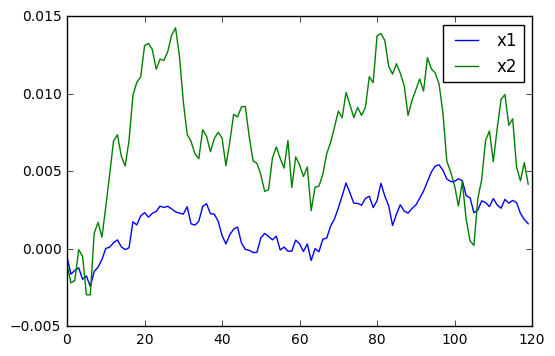

In [16]:
xt,yt= simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, 12, 10)
plot(xt)
legend(['x1','x2'],loc=1)

In [3]:
# test cell
rho_x = 0.5
C = np.asarray([[1,0],[rho_x,1-rho_x*rho_x]]) # Cholesky decomposition of correlation matrix
wt = C.dot(np.random.normal(0,1,(2,)))
print wt.shape
print np.ones(2).shape
print np.diag(np.asarray([2,3]))
print np.arange(1./12,10.00001,1./12)

(2L,)
(2L,)
[[2 0]
 [0 3]]
[  0.08333333   0.16666667   0.25         0.33333333   0.41666667   0.5
   0.58333333   0.66666667   0.75         0.83333333   0.91666667   1.
   1.08333333   1.16666667   1.25         1.33333333   1.41666667   1.5
   1.58333333   1.66666667   1.75         1.83333333   1.91666667   2.
   2.08333333   2.16666667   2.25         2.33333333   2.41666667   2.5
   2.58333333   2.66666667   2.75         2.83333333   2.91666667   3.
   3.08333333   3.16666667   3.25         3.33333333   3.41666667   3.5
   3.58333333   3.66666667   3.75         3.83333333   3.91666667   4.
   4.08333333   4.16666667   4.25         4.33333333   4.41666667   4.5
   4.58333333   4.66666667   4.75         4.83333333   4.91666667   5.
   5.08333333   5.16666667   5.25         5.33333333   5.41666667   5.5
   5.58333333   5.66666667   5.75         5.83333333   5.91666667   6.
   6.08333333   6.16666667   6.25         6.33333333   6.41666667   6.5
   6.58333333   6.66666667   6.75         6

### 4 IMM Exercise